# Hospital Re-admission rate

This data set is downloaded from UC-irvine Machine learning repository https://archive.ics.uci.edu/ml/datasets/diabetes
The dataset contains encounter information regarding patient demographic, vital(s) and re admitted coulmn indicating whether the patient is readmitted in 30 days

Import necessary libraries and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import os
%matplotlib inline

df= pd.read_csv('diabetic_data.csv', header =0)
asdf = pd.read_csv('AdmissionSource.csv', header=0)
atdf = pd.read_csv('AdmissionType.csv', header=0)
dddf = pd.read_csv('DischargeDisposition.csv', header=0)
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Explore Data

In [2]:
# utility functions copied from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# utility function to plot a roc curve

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    


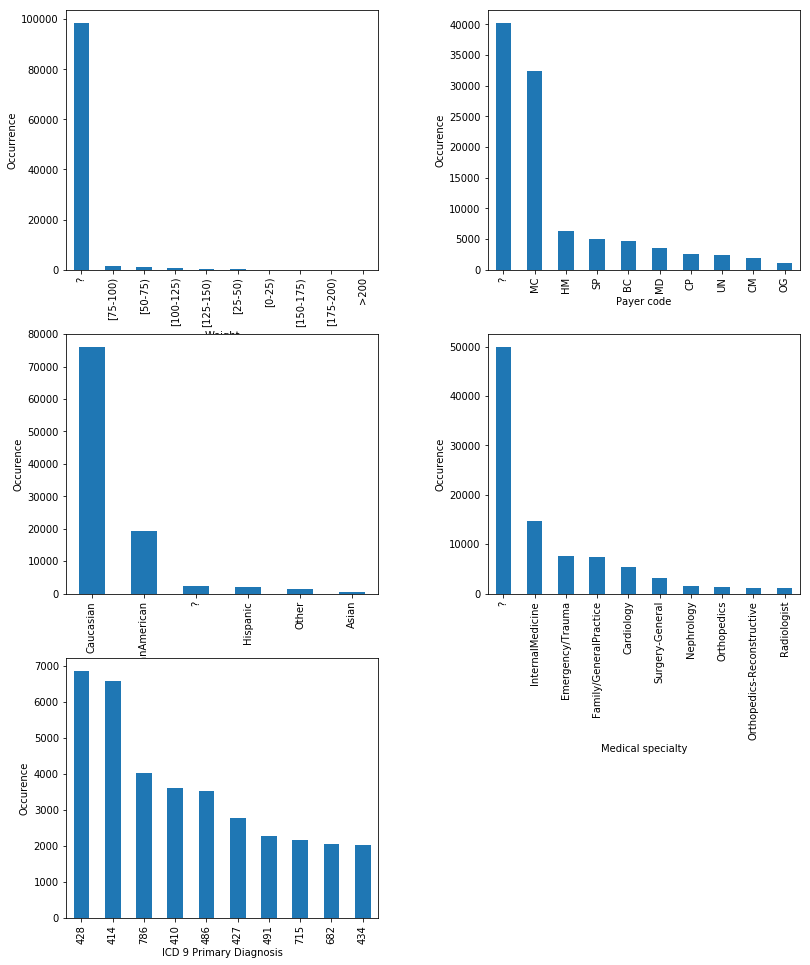

In [4]:
# plot with various axes scales
plt.figure(1, figsize=(12,15))

# weight
plt.subplot(321)
count_weight = pd.value_counts(df['weight'], sort = True).nlargest(10)
count_weight.plot(kind = 'bar')
plt.xlabel("Weight")
plt.ylabel("Occurrence")

#Payer code
plt.subplot(322)
count_pc = pd.value_counts(df['payer_code'], sort = True).nlargest(10)
count_pc.plot(kind = 'bar')
plt.xlabel("Payer code")
plt.ylabel("Occurence")

#Race
plt.subplot(323)
count_race = pd.value_counts(df['race'], sort = True).nlargest(10)
count_race.plot(kind = 'bar')
plt.xlabel("Race")
plt.ylabel("Occurence")

#Medical specialty
plt.subplot(324)
count_ms = pd.value_counts(df['medical_specialty'], sort = True).nlargest(10)
count_ms.plot(kind = 'bar')
plt.xlabel("Medical specialty")
plt.ylabel("Occurence")


# Diagnosis 1

plt.subplot(325)
count_ms = pd.value_counts(df['diag_1'], sort = True).nlargest(10)
count_ms.plot(kind = 'bar')
plt.xlabel("ICD 9 Primary Diagnosis")
plt.ylabel("Occurence")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)

plt.show()

Few features has missing data, represented with '?'. those need to be either imputed with some value or drop the feature <br><br>
Let's observe few vital(s) on patient data, in the data-frame there are around 25 vital's that are collected, for brevity purpose let's observe few vitals

In [5]:
citoglipton_df = pd.DataFrame(pd.value_counts(df['citoglipton'], sort = True))
metformin_pioglitazone_df = pd.DataFrame(pd.value_counts(df['metformin-pioglitazone'], sort = True))
examide_df = pd.DataFrame(pd.value_counts(df['examide'], sort = True))
metformin_rosiglitazone_df = pd.DataFrame(pd.value_counts(df['metformin-rosiglitazone'], sort = True))
glimepiride_pioglitazone_df = pd.DataFrame(pd.value_counts(df['glimepiride-pioglitazone'], sort = True))
max_glu_serum_df = pd.DataFrame(pd.value_counts(df['max_glu_serum'], sort = True))
A1Cresult_df = pd.DataFrame(pd.value_counts(df['A1Cresult'], sort = True))
metformin_df = pd.DataFrame(pd.value_counts(df['metformin'], sort = True))
repaglinide_df = pd.DataFrame(pd.value_counts(df['repaglinide'], sort = True))
nateglinide_df = pd.DataFrame(pd.value_counts(df['nateglinide'], sort = True))
chlorpropamide_df = pd.DataFrame(pd.value_counts(df['chlorpropamide'], sort = True))

vitals_df = pd.concat([citoglipton_df,metformin_pioglitazone_df,examide_df,metformin_rosiglitazone_df,
                       glimepiride_pioglitazone_df,metformin_df,
                      repaglinide_df,nateglinide_df,chlorpropamide_df], join='outer', axis=1)

print(vitals_df)

        citoglipton  metformin-pioglitazone   examide  \
Down            NaN                     NaN       NaN   
No         101766.0                101765.0  101766.0   
Steady          NaN                     1.0       NaN   
Up              NaN                     NaN       NaN   

        metformin-rosiglitazone  glimepiride-pioglitazone  metformin  \
Down                        NaN                       NaN        575   
No                     101764.0                  101765.0      81778   
Steady                      2.0                       1.0      18346   
Up                          NaN                       NaN       1067   

        repaglinide  nateglinide  chlorpropamide  
Down             45           11               1  
No           100227       101063          101680  
Steady         1384          668              79  
Up              110           24               6  


The following vitals are completely skewed and can be dropped from the data frame
- citoglipton
- metformin-pioglitazone
- examide
- metformin-rosiglitazone
- glimepiride-pioglitazone
 

Replace the '?' value with None value, and observe how many records are populated

In [6]:
df.loc[df['weight'] =='?', 'weight']=None
df.loc[df['payer_code'] =='?', 'payer_code']=None
df.loc[df['medical_specialty'] =='?', 'medical_specialty']=None
df.loc[df['diag_2'] =='?', 'diag_2']=None
df.loc[df['diag_3'] =='?', 'diag_3']=None
df.loc[df['race'] =='?', 'race']='Other'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 no

Only 3197 records had the weight populated, cannot use Imputer to fill the missing values, as weight varies by age of the individual. The other two features that doesn't have values are payer_code and medical_specialty. Let's plot the Payer code and medical_specialty to see what those values are

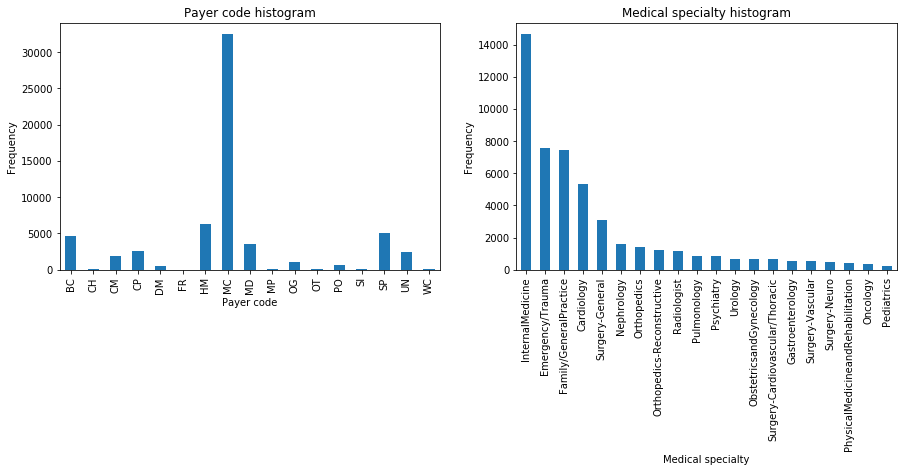

In [8]:
plt.figure(1,figsize=(15,10))

plt.subplot(221)
count_pc = pd.value_counts(df['payer_code'], sort = True).sort_index()
count_pc.plot(kind = 'bar')
plt.title("Payer code histogram")
plt.xlabel("Payer code")
plt.ylabel("Frequency")
#plt.grid(True)

# medical_specialty

plt.subplot(222)
count_ms = pd.value_counts(df['medical_specialty'], sort = True).nlargest(20)
count_ms.plot(kind = 'bar')
plt.title("Medical specialty histogram")
plt.xlabel("Medical specialty")
plt.ylabel("Frequency")
#plt.grid(True)

plt.show()

Let's observe how skewed the data set is for the target feature 're-admitted'

In [9]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

Functions that transform feature on the dataframe

In [10]:
def convert_age(row):
    val = row['age']
    if(val  =='[0-10)') or (val == '[10-20') : 
      return 'young';
    if(val  =='[20-30)') or (val == '[30-40)') or (val == '[40-50)') :
      return 'adult'
    if(val  =='[50-60)') or (val == '[60-70)') or (val == '[70-80)') or (val == '[80-90)') or (val == '[90-100)'):
      return 'old';
    return 'old';

In [11]:
def convert_admission(row):
    val = row['readmitted']
    if (val == '<30'):
        return 1;
    if (val == '>30') :
        return 0;
    return 0;

Convert the age and readmitted column values of the dataframe

In [12]:
df['age'] = df.apply(lambda row: convert_age(row), axis=1)
df['readmitted'] = df.apply(lambda row: convert_admission(row), axis =1)

Drop the columns from the dataframe that has insufficient values and in siginificant values <br>
encounter_id is the index of the dataframe and patient_nbr is random number assigned to a patient.


In [13]:
df = df.drop(['encounter_id','patient_nbr','payer_code','weight','medical_specialty'], axis=1)

In [14]:
df= df.drop(['examide', 'citoglipton','metformin-pioglitazone','metformin-rosiglitazone','glimepiride-pioglitazone'], axis=1)

Applying Label Encoder for the categorical columns, we will have another notebook using one hot encoder and PCA on the same data set

In [15]:
df['race'] = df['race'].astype('category')
df['gender'] = df['gender'].astype('category')
df['age'] = df['age'].astype('category')
df['diag_1'] = df['diag_1'].astype('category')
df['diag_2'] = df['diag_2'].astype('category')
df['diag_3'] = df['diag_3'].astype('category')
df['max_glu_serum'] = df['max_glu_serum'].astype('category')
df['A1Cresult'] = df['A1Cresult'].astype('category')
df['metformin'] = df['metformin'].astype('category')
df['repaglinide'] = df['repaglinide'].astype('category')
df['nateglinide'] = df['nateglinide'].astype('category')
df['chlorpropamide'] = df['chlorpropamide'].astype('category')
df['glimepiride'] = df['glimepiride'].astype('category')
df['acetohexamide'] = df['acetohexamide'].astype('category')
df['glipizide'] = df['glipizide'].astype('category')
df['glyburide'] = df['glyburide'].astype('category')
df['tolbutamide'] = df['tolbutamide'].astype('category')
df['pioglitazone'] = df['pioglitazone'].astype('category')
df['rosiglitazone'] = df['rosiglitazone'].astype('category')
df['acarbose'] = df['acarbose'].astype('category')
df['miglitol'] = df['miglitol'].astype('category')
df['troglitazone'] = df['troglitazone'].astype('category')
df['tolazamide'] = df['tolazamide'].astype('category')
# df['examide'] = df['examide'].astype('category')
# df['citoglipton'] = df['citoglipton'].astype('category')
df['insulin'] = df['insulin'].astype('category')
df['glyburide-metformin'] = df['glyburide-metformin'].astype('category')
df['glipizide-metformin'] = df['glipizide-metformin'].astype('category')
# df['glimepiride-pioglitazone'] = df['glimepiride-pioglitazone'].astype('category')
# df['metformin-rosiglitazone'] = df['metformin-rosiglitazone'].astype('category')
# df['metformin-pioglitazone'] = df['metformin-pioglitazone'].astype('category')
df['change'] = df['change'].astype('category')
df['diabetesMed'] = df['diabetesMed'].astype('category')




In [16]:
df['race'] = df['race'].cat.codes
df['gender'] = df['gender'].cat.codes
df['age'] = df['age'].cat.codes
df['diag_1'] = df['diag_1'].cat.codes
df['diag_2'] = df['diag_2'].cat.codes
df['diag_3'] = df['diag_3'].cat.codes
df['max_glu_serum'] = df['max_glu_serum'].cat.codes
df['A1Cresult'] = df['A1Cresult'].cat.codes
df['metformin'] = df['metformin'].cat.codes
df['repaglinide'] = df['repaglinide'].cat.codes
df['nateglinide'] = df['nateglinide'].cat.codes
df['chlorpropamide'] = df['chlorpropamide'].cat.codes
df['glimepiride'] = df['glimepiride'].cat.codes
df['acetohexamide'] = df['acetohexamide'].cat.codes
df['glipizide'] = df['glipizide'].cat.codes
df['glyburide'] = df['glyburide'].cat.codes
df['tolbutamide'] = df['tolbutamide'].cat.codes
df['pioglitazone'] = df['pioglitazone'].cat.codes
df['rosiglitazone'] = df['rosiglitazone'].cat.codes
df['acarbose'] = df['acarbose'].cat.codes
df['miglitol'] = df['miglitol'].cat.codes
df['troglitazone'] = df['troglitazone'].cat.codes
df['tolazamide'] = df['tolazamide'].cat.codes
# df['examide'] = df['examide'].cat.codes
# df['citoglipton'] = df['citoglipton'].cat.codes
df['insulin'] = df['insulin'].cat.codes
df['glyburide-metformin'] = df['glyburide-metformin'].cat.codes
df['glipizide-metformin'] = df['glipizide-metformin'].cat.codes
# df['glimepiride-pioglitazone'] = df['glimepiride-pioglitazone'].cat.codes
# df['metformin-rosiglitazone'] = df['metformin-rosiglitazone'].cat.codes
# df['metformin-pioglitazone'] = df['metformin-pioglitazone'].cat.codes
df['change'] = df['change'].cat.codes
df['diabetesMed'] = df['diabetesMed'].cat.codes

Observe the data type of features, they got converted from  object to either int8/int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 40 columns):
race                        101766 non-null int8
gender                      101766 non-null int8
age                         101766 non-null int8
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null int16
diag_2                      101766 non-null int16
diag_3                      101766 non-null int16
number_diagnoses            101766 non-null int64
max_glu_serum               101766 non-nul

In [18]:
df.head(5)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted
0,2,0,2,6,25,1,1,41,0,1,...,1,1,0,0,1,1,0,1,0,0
1,2,0,1,1,1,7,3,59,0,18,...,1,1,0,0,3,1,0,0,1,0
2,0,0,0,1,1,7,2,11,5,13,...,1,1,0,0,1,1,0,1,1,0
3,2,1,0,1,1,7,2,44,1,16,...,1,1,0,0,3,1,0,0,1,0
4,2,1,0,1,1,7,1,51,0,8,...,1,1,0,0,2,1,0,0,1,0


Let's observe how skewed the data set is 

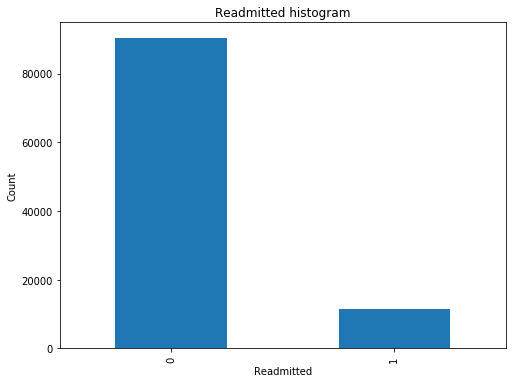

In [19]:
plt.figure(1,figsize=(8,6))

plt.subplot(111)
count_pc = pd.value_counts(df['readmitted'], sort = True).sort_index()
count_pc.plot(kind = 'bar')
plt.title("Readmitted histogram")
plt.xlabel("Readmitted")
plt.ylabel("Count")
plt.show()

In [20]:
y= df['readmitted']
X= df.drop(['readmitted'], axis =1)

In [21]:
X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X,y, test_size=.30, random_state=0)
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=12)
model.fit(X_us_train, y_us_train)
y_us_predict = model.predict(X_us_test)
accuracy_score(y_us_test, y_us_predict)

0.88221421552571244

In [22]:
cnf_matrix = confusion_matrix(y_us_test, y_us_predict)

Confusion matrix, without normalization


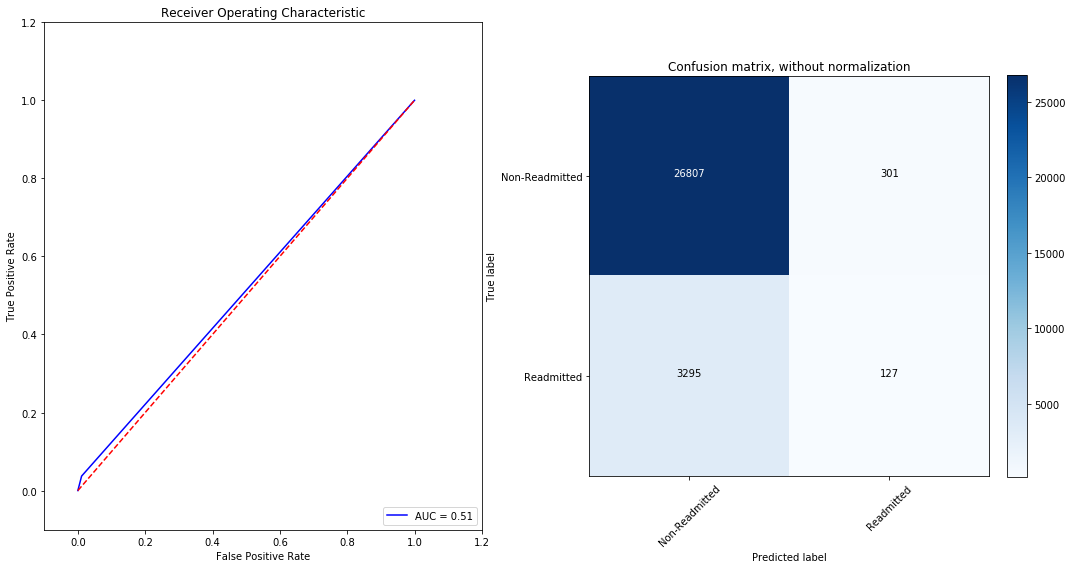

In [23]:
plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_us_test, y_us_predict)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=['Non-Readmitted','Readmitted'],
                      title='Confusion matrix, without normalization')

plt.show()

Because of the data is unbalanced, use the SMOTEENN method to under/over sample the data to have both classes represents significantly on the training data set

In [24]:
smote_enn = SMOTEENN(random_state=0)
X_rs,y_rs = smote_enn.fit_sample(X,y)

After re-sampling, count of non-readmitted and re-admitted observations are as below

In [25]:
from collections import Counter
print(sorted(Counter(y_rs).items()))

[(0, 49682), (1, 82927)]


#tune for parameters of decision tree: criterion, max_depth

In [26]:
dt_params ={'criterion':['gini','entropy'], 'max_depth':[10,12,14]}
dt = tree.DecisionTreeClassifier()
dt_gscv = GridSearchCV(dt,param_grid = dt_params, scoring='accuracy')
dt_gscv.fit(X_rs,y_rs)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 12, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [27]:
dt_gscv.best_params_

{'criterion': 'entropy', 'max_depth': 12}

In [28]:
dt_gscv.cv_results_

C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([ 0.7711134 ,  0.81757752,  0.70919689,  0.80738576,  0.98968728,
         0.91156348]),
 'mean_score_time': array([ 0.01038424,  0.01285823,  0.01041857,  0.01041857,  0.01562754,
         0.0052096 ]),
 'mean_test_score': array([ 0.86173638,  0.86519769,  0.86739211,  0.84899969,  0.87170554,
         0.86898325]),
 'mean_train_score': array([ 0.89369166,  0.91041373,  0.92595561,  0.8908525 ,  0.90824573,
         0.92204944]),
 'param_criterion': masked_array(data = ['gini' 'gini' 'gini' 'entropy' 'entropy' 'entropy'],
              mask = [False False False False False False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [10 12 14 10 12 14],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'criterion': 'gini', 'max_depth': 10},
  {'criterion': 'gini', 'max_depth': 12},
  {'criterion': 'gini', 'max_depth': 14},
  {'criterion': 'entropy', 'max_depth': 10},
  {'criterion': 'entropy', 'max_dep

In [29]:
# tuning for optimal parameter is not done, will do it a new version of notebook
X_train, X_test, y_train, y_test = train_test_split(X_rs,y_rs, test_size=.30, random_state=0)
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=12)


In [30]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)
cnf_matrix = confusion_matrix(y_test, y_predict)

Confusion matrix, without normalization


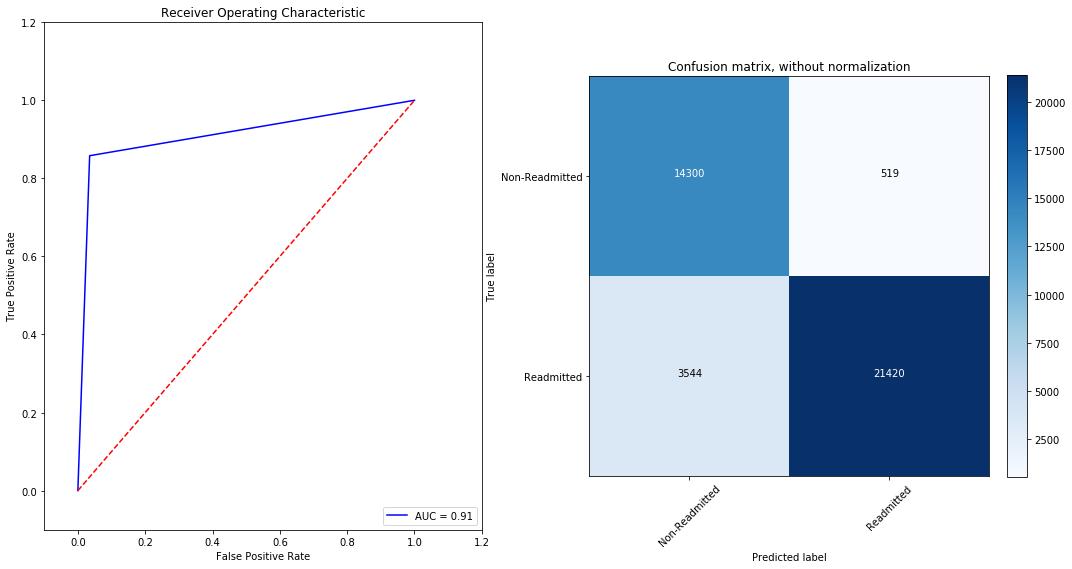

In [32]:
plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_test, y_predict)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=['Non-Readmitted','Readmitted'],
                      title='Confusion matrix, without normalization')

plt.show()

In [33]:
#generate the tree png file - Run this cell if the machine has graphviz installed, other wise ignore this cell

with open("readmission.dot","w") as f:
    f = tree.export_graphviz(model, out_file = f)
    
import pydot

(graph,) = pydot.graph_from_dot_file('readmission.dot')
graph.write_png('readmission.png')

True

### Bagging

Let's ensemble the decision trees to form a Random forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0)
random_forest.fit(X_train, y_train)

y_predict = random_forest.predict(X_test)
accuracy_score(y_test, y_predict)

0.91312872332403283

In [35]:
cnf_matrix = confusion_matrix(y_test, y_predict)

Confusion matrix, without normalization


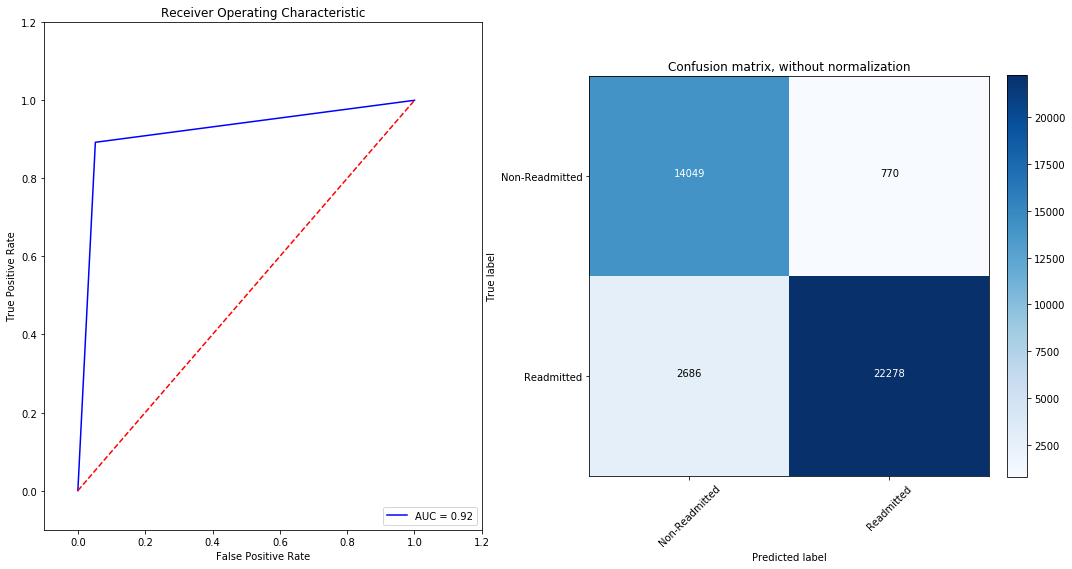

In [36]:
plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_test, y_predict)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=['Non-Readmitted','Readmitted'],
                      title='Confusion matrix, without normalization')

plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


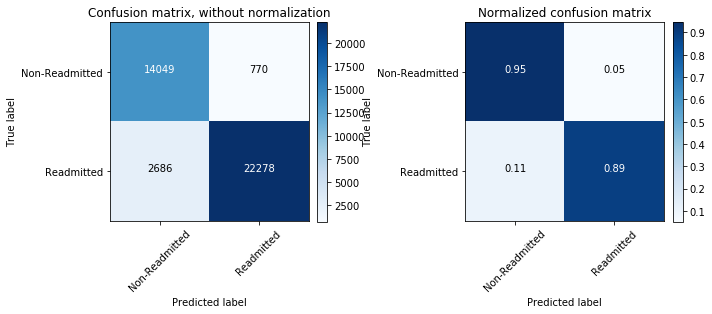

In [37]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(1, figsize=(10,6))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=['Non-Readmitted','Readmitted'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=['Non-Readmitted','Readmitted'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

the following matrix gives the significance of each feature in classifying the observation

In [38]:
np.set_printoptions(precision=3, suppress=True)

In [39]:
random_forest.feature_importances_

array([ 0.03 ,  0.081,  0.016,  0.022,  0.095,  0.029,  0.034,  0.008,
        0.02 ,  0.011,  0.017,  0.031,  0.194,  0.01 ,  0.008,  0.007,
        0.026,  0.002,  0.005,  0.058,  0.   ,  0.   ,  0.   ,  0.003,
        0.   ,  0.02 ,  0.014,  0.   ,  0.009,  0.005,  0.   ,  0.   ,
        0.   ,  0.   ,  0.052,  0.   ,  0.   ,  0.1  ,  0.093])

The top 5 features that impact the re-admission
- X[12]
- X[38]
- X[4]
- X[39]
- X[1]

### Boosting
<br>
Lets do some xgb analysis on the data set and see any improvments

In [40]:
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [41]:
import xgboost as xgb
cv_params = {'max_depth': [10,12,14]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 200, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [42]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 12, 14]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [43]:
optimized_GBM.cv_results_

C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\rmali\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([ 77.858,  91.806,  93.085]),
 'mean_score_time': array([ 0.721,  1.072,  0.888]),
 'mean_test_score': array([ 0.924,  0.924,  0.924]),
 'mean_train_score': array([ 0.969,  0.99 ,  0.998]),
 'param_max_depth': masked_array(data = [10 12 14],
              mask = [False False False],
        fill_value = ?),
 'params': [{'max_depth': 10}, {'max_depth': 12}, {'max_depth': 14}],
 'rank_test_score': array([1, 3, 2]),
 'split0_test_score': array([ 0.925,  0.924,  0.924]),
 'split0_train_score': array([ 0.969,  0.989,  0.998]),
 'split1_test_score': array([ 0.923,  0.923,  0.923]),
 'split1_train_score': array([ 0.969,  0.99 ,  0.998]),
 'split2_test_score': array([ 0.923,  0.923,  0.923]),
 'split2_train_score': array([ 0.969,  0.99 ,  0.999]),
 'split3_test_score': array([ 0.926,  0.925,  0.925]),
 'split3_train_score': array([ 0.969,  0.99 ,  0.999]),
 'split4_test_score': array([ 0.925,  0.925,  0.925]),
 'split4_train_score': array([ 0.969,  0.989,  0.998]),
 'st

In [44]:
xgd_mat= xgb.DMatrix(X_train,y_train)

In [45]:
tuned_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':14} 

In [46]:
cv_xgb = xgb.cv(params = tuned_params, dtrain = xgd_mat, num_boost_round = 1000, nfold = 5,
                metrics = ['error'],
                early_stopping_rounds = 100)

In [47]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
212,0.075636,0.002707,0.001190,0.000181
213,0.075669,0.002610,0.001134,0.000180
214,0.075712,0.002699,0.001109,0.000169
215,0.075658,0.002720,0.001093,0.000157
216,0.075582,0.002646,0.001083,0.000155


In [48]:
readmit_gb = xgb.train(tuned_params, xgd_mat, num_boost_round = 216)

In [49]:
import seaborn as sns

In [50]:
importances = readmit_gb.get_score()
importances

{'f0': 1846,
 'f1': 2018,
 'f10': 1835,
 'f11': 1272,
 'f12': 2955,
 'f13': 14173,
 'f14': 13366,
 'f15': 12841,
 'f16': 4444,
 'f17': 421,
 'f18': 1345,
 'f19': 1168,
 'f2': 931,
 'f20': 136,
 'f21': 48,
 'f22': 2,
 'f23': 331,
 'f25': 1062,
 'f26': 866,
 'f28': 497,
 'f29': 437,
 'f3': 3110,
 'f30': 22,
 'f33': 2,
 'f34': 3405,
 'f35': 33,
 'f37': 1717,
 'f38': 979,
 'f4': 4619,
 'f5': 2735,
 'f6': 7198,
 'f7': 12246,
 'f8': 4362,
 'f9': 11190}

In [51]:
testdmat = xgb.DMatrix(X_test)
y_xgd_pred = readmit_gb.predict(testdmat)

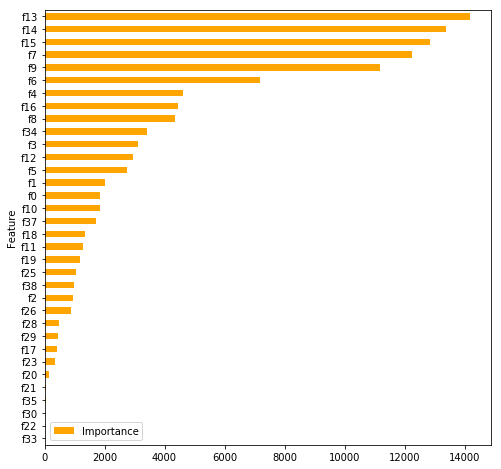

In [52]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

In [53]:
y_xgd_pred[y_xgd_pred > 0.5] = 1
y_xgd_pred[y_xgd_pred <= 0.5] = 0

In [55]:
print(accuracy_score(y_test, y_xgd_pred))
cnf_matrix = confusion_matrix(y_test, y_xgd_pred)

0.926878314858


Confusion matrix, without normalization


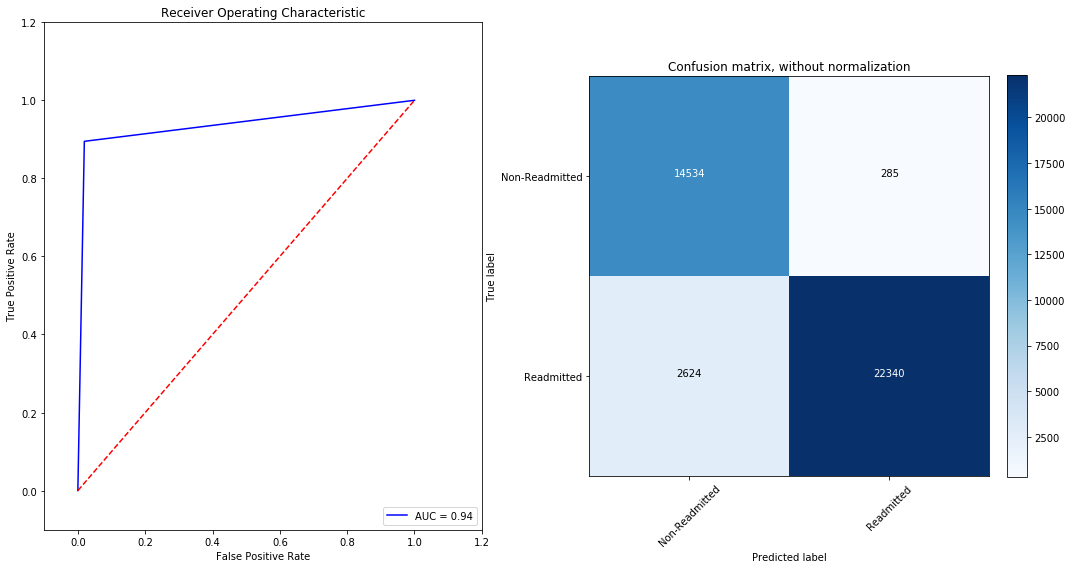

In [57]:
plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_test, y_xgd_pred)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=['Non-Readmitted','Readmitted'],
                      title='Confusion matrix, without normalization')

plt.show()